In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.signal import stft
import os
import pandas as pd
import sys
import glob
import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math
from sklearn.preprocessing import MinMaxScaler
import nbimporter
from transformer_model import WordPiece, Evaluator, BlandAltman2, Objective, BestModelLoader, normalize_data1, normalize_data2, denormalize_data,scatter,find_ids
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score
from torch.nn.utils.rnn import pad_sequence
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders
import optuna
import json
from dataprocess import OutputDataProcessor, DataProcessor, pad_truncate_sequences
import pickle

In [3]:
import torch
print(torch.__version__)
import sklearn
print(sklearn.__version__)


2.0.0+cu117
1.2.2


In [4]:
import logging
import random
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode).
        When seed is a false-y value or not supplied, disables deterministic mode. """

    if seed:
        logging.info(f"Running in deterministic mode with seed {seed}")
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info(f"Running in non-deterministic mode")

set_seed(0)

In [5]:
processor = OutputDataProcessor('F:\junwei\dataset\_MASTER_modified.xlsx')
output_data,min_resistance, max_resistance,min_compliance, max_compliance = processor.process()

In [6]:
data = np.load(r'F:\junwei\transformer\10HZ(800)\final_dataset_less.npy')

In [12]:
#import numpy as np
#from sklearn.preprocessing import OneHotEncoder

#tokens = np.unique(data)  # Find unique tokens


#token_dict = {word: i for i, word in enumerate(tokens)}

#enc = OneHotEncoder(sparse=False)
#encoded_array = np.vectorize(token_dict.get)(data)


In [7]:
#sequence_tokenizer = WordPiece(vocab_size=120,max_seq_len=60)
#sequence_tokenizer.train_tokenizer(data)
#directory  = r'F:\junwei\final_tranformer\transformer_C _R\wordpiece'

#file_path = os.path.join(directory, 'sequence_tokenizer.pkl')
#with open(file_path, 'wb') as f:
 #  pickle.dump(sequence_tokenizer, f)

directory = r'F:\junwei\final_tranformer\transformer_C _R\wordpiece'
file_path = os.path.join(directory, 'sequence_tokenizer(100).pkl')

with open(file_path, 'rb') as f:
    loaded_sequence_tokenizer = pickle.load(f)

padded_data = loaded_sequence_tokenizer.tokenize_and_pad(data)
vocab = loaded_sequence_tokenizer.tokenizer.get_vocab()
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 100


In [14]:

#reverse_vocab = {v: k for k, v in vocab.items()}


#for i in range(len(data)):
    # Extract a sentence from the original and new dataset
 #   original_sentence = data[i]
  #  new_sentence = padded_data[i]

   
   # decoded_sentence = [reverse_vocab[token] if token in reverse_vocab else '[UNK]' for token in new_sentence]

   
    #was_split = len(decoded_sentence) > len(original_sentence)

   
    #print(f"Sentence {i}:")
    #print(f"Original sentence: {original_sentence}")
    #print(f"Decoded sentence: {' '.join(decoded_sentence)}")
    #print(f"Was split: {was_split}")


In [15]:
#new_data = pad_truncate_sequences(padded_data)

In [8]:
processor = DataProcessor(padded_data, output_data, seed1=42, seed2 = 17)#padded_data
processor.prepare_data()
train_loader, valid_loader, test_loader, train_data, val_data, test_data, train_indices, val_indices, test_indices = processor.get_loaders()

In [9]:
train_data.to_csv(r'F:\junwei\CNN\CNN_keras\train.csv', index=True)
val_data.to_csv(r'F:\junwei\CNN\CNN_keras\val.csv', index=True)
test_data.to_csv(r'F:\junwei\CNN\CNN_keras\test.csv', index=True)

In [18]:
#train_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\train_data.pickle')
#test_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\test_data.pickle')
#val_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\val_data.pickle')

In [ ]:
d_model_options = [16, 32, 64, 128, 256, 512, 1024]
nhead_options = [2, 4, 8,16]
num_layers_range = (1, 20)
dropout_range = (0.01, 0.5)
lr_range = (1e-5, 1e-2)
weight_decay = (1e-6, 1e-2)
num_hidden_layers_range=(1, 5)
hidden_dim_range=[64,128, 256, 512, 1024]
n_trials = 130
vocab_size = 5000
max_seq_len = 50
output_dim = 2
num_epochs = 1000
patience = 30
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
device = torch.device('cuda')
objective = Objective(train_loader, valid_loader, device, d_model_options, nhead_options, num_layers_range, dropout_range, lr_range, n_trials, vocab_size, max_seq_len, output_dim, num_epochs, patience, weight_decay,num_hidden_layers_range,hidden_dim_range)
best_value, best_params = objective.optimize()
objective.plot_losses()

In [20]:
print(f"Best trial:")
print(f"  Value: {best_value:.4f}")
print(f"  Params: {best_params}")

Best trial:
  Value: 0.0763
  Params: {'d_model': 64, 'nhead': 4, 'weight_decay': 0.000746987494264532, 'num_layers': 3, 'dropout': 0.15149061774712727, 'lr': 5.8683983710331895e-05, 'num_hidden_layers': 5, 'hidden_dim_0': 64, 'hidden_dim_1': 128, 'hidden_dim_2': 256, 'hidden_dim_3': 512, 'hidden_dim_4': 64, 'hidden_layers': [64, 128, 256, 512, 64]}


In [10]:
processor1 = DataProcessor(padded_data, output_data,seed1=42,seed2 = 17)
train_data1, val_data1, test_data1, train_indices1, val_indices1, test_indices1 = processor1.process_padded_data()
dataset1 = pd.read_excel(r'F:\junwei\dataset\_MASTER_MAFAI2023_456cases.xlsx')

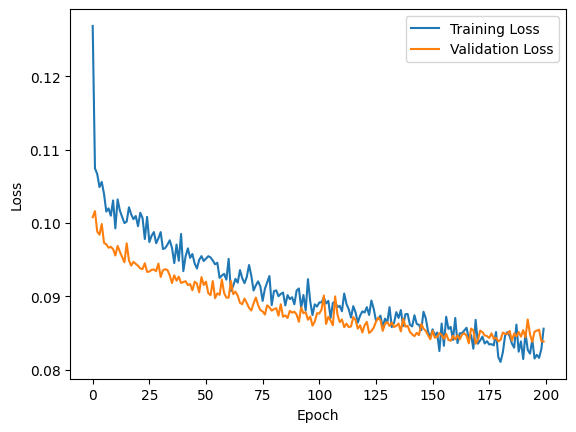

In [12]:
file_path = r'F:\junwei\final_tranformer\all_trails_(10HZ-800)_C_R\trial_10.pkl'
#file_path = r'F:\junwei\final_tranformer\best_model_C_R(10HZ-800)\trial_17(10HZ-800,800VOCAB).pkl'
vocab_size = 5000
max_seq_len = 50
output_dim = 2
device = torch.device('cuda')
loader = BestModelLoader(file_path, vocab_size, max_seq_len, output_dim, device)
model, best_train_losses, best_valid_losses = loader.load_best_model()
model.eval()
loader.plot_loss(best_train_losses, best_valid_losses)
preds, targets = loader.test_model(model, test_loader)
R_pre = denormalize_data(preds[:,1],min_resistance, max_resistance)
C_pre = denormalize_data(preds[:,0],min_compliance, max_compliance)
R_true = denormalize_data(targets[:,1],min_resistance, max_resistance)
C_true = denormalize_data(targets[:,0],min_compliance, max_compliance)

In [11]:
#preds1, targets1 = loader.test_model(model, train_loader)
##R_pre = denormalize_data(preds1[:,1],min_resistance, max_resistance)
#C_pre = denormalize_data(preds1[:,0],min_compliance, max_compliance)
#R_true = denormalize_data(targets1[:,1],min_resistance, max_resistance)
#C_true = denormalize_data(targets1[:,0],min_compliance, max_compliance)

In [12]:
#evaluator_c = Evaluator(C_true, C_pre)
#evaluator_r = Evaluator(R_true, R_pre)

#mse1, mae1, nmse1, mape1,r2_1 = evaluator_c.evaluate()

#mse2, mae2, nmse2, mape2,r2_2 = evaluator_r.evaluate()

#evl = {'Metric': ['MSE','MAE', 'NMSE', 'MAPE'],
        'C': [mse1,mae1, nmse1, mape1],
        'R': [mse2,mae2, nmse2, mape2]
 #       }

#results_df = pd.DataFrame(evl)

#results_df.set_index('Metric', inplace=True)

#print(results_df)


                 C          R
Metric                       
MSE     105.372330  18.658060
MAE       8.215772   3.163251
NMSE      0.774573   0.936656
MAPE     21.426654  23.191972


In [13]:
evaluator_c = Evaluator(C_true, C_pre)
evaluator_r = Evaluator(R_true, R_pre)

mse1, mae1, nmse1, mape1,r2_1 = evaluator_c.evaluate()

mse2, mae2, nmse2, mape2,r2_2 = evaluator_r.evaluate()

evl = {'Metric': ['MSE','MAE', 'NMSE', 'MAPE'],
        'C': [mse1,mae1, nmse1, mape1],
        'R': [mse2,mae2, nmse2, mape2]
        }

results_df = pd.DataFrame(evl)

results_df.set_index('Metric', inplace=True)

print(results_df)


                C          R
Metric                      
MSE     96.044350  24.796883
MAE      6.913431   3.011282
NMSE     0.848955   0.933645
MAPE    15.654430  20.675558


In [34]:
with open(loader.path, 'rb') as f:
    _, best_params, _, _ = pickle.load(f)

print("Best parameters:")
for key, value in best_params.items():
    print(f"    {key}: {value}")

Best parameters:
    d_model: 16
    nhead: 2
    weight_decay: 0.00011291276502083395
    num_layers: 5
    dropout: 0.04052500891738709
    lr: 1.4002725175637515e-05
    num_hidden_layers: 1
    hidden_dim_0: 64
    hidden_layers: [64]


In [29]:
C_pre1 = pd.DataFrame(C_pre,columns =['C_pre'])
#C_pre1.C_pre.quantile([0.25,0.5,0.75])
C_pre1.C_pre.describe()

count    67.000000
mean     45.338779
std       6.278931
min      30.402512
25%      41.989075
50%      45.294830
75%      48.512943
max      64.459404
Name: C_pre, dtype: float64

In [34]:
C_true = pd.DataFrame(C_true,columns =['C_true'])
R_true = pd.DataFrame(R_true,columns =['R_ture'])

In [30]:
R_pre1 = pd.DataFrame(R_pre,columns =['R_pre'])
#C_pre1.C_pre.quantile([0.25,0.5,0.75])
R_pre1.R_pre.describe()

count    67.000000
mean     15.105688
std       1.120512
min      11.724149
25%      14.340331
50%      15.160358
75%      15.798424
max      17.519093
Name: R_pre, dtype: float64

In [12]:
import numpy as np
import matplotlib.pyplot as plt

class BlandAltman2:
    def __init__(self, output_data_unscaled, pre_data_unscaled):
        self.output_data_unscaled = output_data_unscaled
        self.pre_data_unscaled = pre_data_unscaled

    def plot(self, x_label, start, xlim_range,start_y,ylim_range):
        # Convert the values to numpy arrays
        output_data = np.asarray(self.output_data_unscaled)
        pre_data = np.asarray(self.pre_data_unscaled)

    
        diff = output_data - pre_data
        mean = (output_data + pre_data) / 2

        # Calculate the percentage difference between predictions and targets
        percentage_diff = (diff / mean) * 100

        # Calculate the mean and standard deviation of the percentage difference
        mean_diff = np.mean(percentage_diff)
        std_diff = np.std(percentage_diff)

        overestimate_indices = []
        underestimate_indices = []
        # Find indices of outliers
        outlier_indices = []

        for i, percentage_error in enumerate(percentage_diff):
            if percentage_error > 20:  # overestimate
                outlier_indices.append(i)
                overestimate_indices.append(i)
            elif percentage_error < -20:  # underestimate
                outlier_indices.append(i)
                underestimate_indices.append(i)

        # Plot the Bland-Altman plot with percentage difference
        fig, ax = plt.subplots(figsize=(8, 5.5))
        for i in range(len(percentage_diff)):
            if i in outlier_indices:
                ax.scatter(output_data[i], percentage_diff[i], color='red', s=15)
            else:
                ax.scatter(output_data[i], percentage_diff[i], color='blue', s=15)
        ax.axhline(mean_diff, color='gray', linestyle='--',lw = 2)
        upper_limit = mean_diff + 1.96 * std_diff
        lower_limit = mean_diff - 1.96 * std_diff
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--',lw = 2)
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--',lw = 2)
        ax.axhline(20, color='green', linestyle='-',lw = 2.5)
        ax.axhline(-20, color='green', linestyle='-',lw = 2.5)
        ax.set_xlabel(x_label, fontsize=14)
        ax.set_ylabel('Percentage Difference between Predictions and Targets', fontsize=11)
        #ax.set_title('Bland-Altman Plot', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlim(start, xlim_range)
        ax.set_ylim(start_y, ylim_range)
        #yticks = np.arange(start_y, ylim_range + 1, 10)  
        #plt.yticks(yticks)
        ax.set_yticks([-60,-50,-40,-30,-20,-10, 0, 10,20,30,40,50,60])
        plt.show()
        print("The Y-coordinate for the upper gray line is: ", upper_limit)
        print("The Y-coordinate for the lower gray line is: ", lower_limit)
        print(f"Mean difference line Y-value: {mean_diff}")
        # Print indices of outliers
        #print("Indices of outliers: ", outlier_indices)
        #print("Indices of overestimations: ", overestimate_indices)
        #print("Indices of underestimations: ", underestimate_indices)
        return outlier_indices, overestimate_indices, underestimate_indices


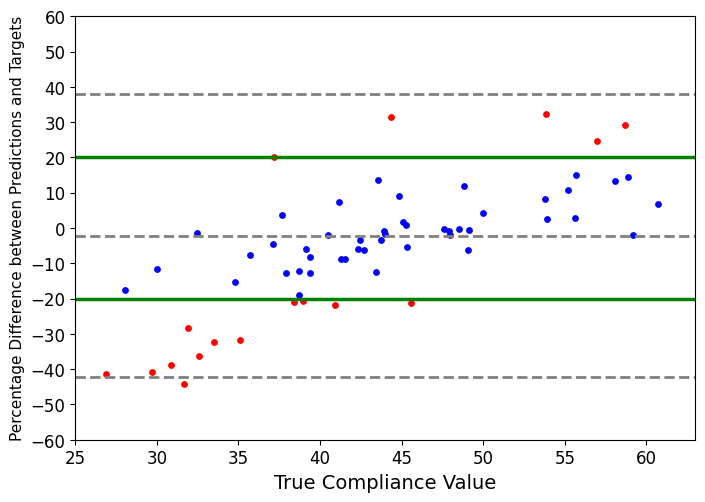

The Y-coordinate for the upper gray line is:  37.83703845024109
The Y-coordinate for the lower gray line is:  -42.129681520462036
Mean difference line Y-value: -2.1463215351104736


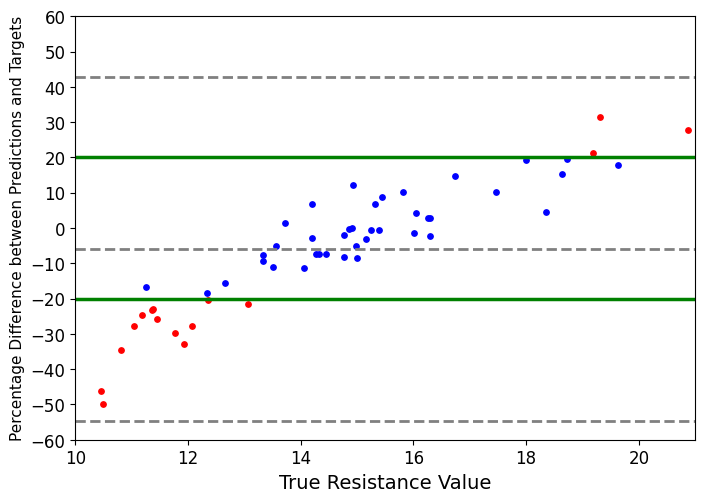

The Y-coordinate for the upper gray line is:  42.898833446502685
The Y-coordinate for the lower gray line is:  -54.835956745147705
Mean difference line Y-value: -5.96856164932251


In [18]:
bland_C = BlandAltman2(C_true, C_pre)
bland_R = BlandAltman2(R_true, R_pre)

outlier_indices_C = bland_C.plot('True Compliance Value',25,63,-50,50)
outlier_indices_R = bland_R.plot('True Resistance Value',10,21,-60,50) 

In [15]:
#name1 = "Compliance"
#scatter(C_true, C_pre,name1)
#name2 = "Resistance"
#scatter(R_true, R_pre,name2)

In [20]:
indices = [90, 110, 66, 287, 7, 355, 148, 244, 358, 70, 11, 311, 116, 388, 176, 42, 22, 31, 19, 30, 280, 316, 25, 33, 60, 423, 402, 153]
df_filtered = test_data1.loc[~test_data1.index.isin(indices)]
df_filtered.index

Index([ 46, 239,  26, 172, 409, 332,  78, 298, 440, 284, 291, 436, 108, 386,
       415, 173, 157, 132, 238, 399,  45, 237,  73, 154,  76, 286, 329,  84,
        57, 185,  77,  82, 333, 203,  18, 104, 155, 140, 126],
      dtype='int64')

In [15]:
id_list_C = [2, 3, 12, 28, 34, 43, 50, 66]

id_list_R = [1, 2, 3, 4, 7, 12, 13, 20, 22, 23, 25, 26, 28, 32, 34, 37, 38, 41, 43, 45, 50, 53, 54, 55, 58, 62, 63, 65]

outlier_C, ID_C = find_ids(id_list_C, test_data1, dataset1)
outlier_R, ID_R = find_ids(id_list_R, test_data1, dataset1)
#outlier_C.to_excel(r"F:\junwei\final_tranformer\transformer_C _R\outliers\outlier_C.xlsx", index=False)
#outlier_R.to_excel(r"F:\junwei\final_tranformer\transformer_C _R\outliers\outlier_R.xlsx", index=False)
print(ID_R)

[8.0, 25.0, 28.0, 29.0, 53.0]


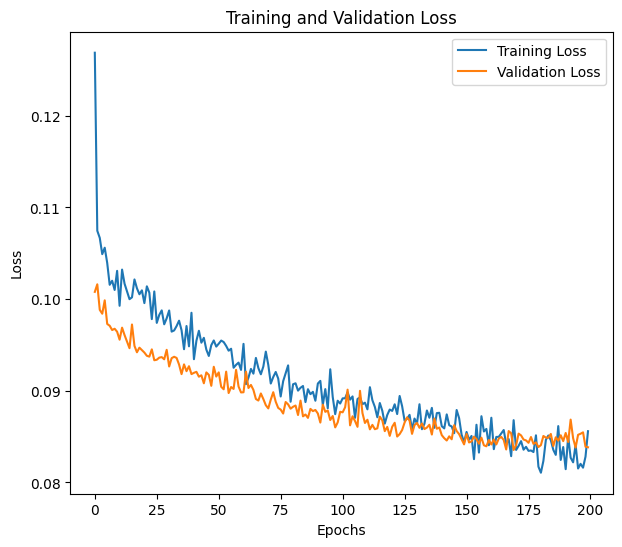

In [16]:
plt.figure(figsize=(7,6))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_valid_losses, label='Validation Loss')
#plt.ylim(0,0.05)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [35]:
#index1 = 296
#plt.figure()
#plt.plot(flow[index1])
#plt.xlabel('Time')
#plt.ylabel('Flow')
#plt.title('Flow - Sample {}'.format(index1))
#plt.show()

# Plot for pressure
#plt.figure()
#plt.plot(pressure[index1])
#plt.xlabel('Time')
#plt.ylabel('Pressure')
#plt.title('Pressure - Sample {}'.format(index1))
#plt.show()

# Plot for volume
##plt.figure()
#plt.plot(volume[index1])
#plt.xlabel('Time')
#plt.ylabel('Volume')
#plt.title('Volume - Sample {}'.format(index1))
#plt.show()

In [36]:
#plt.scatter(C_true, C_pre)

# Add labels and title
##plt.xlabel('C_true')
#plt.ylabel('C_pre')
#plt.title('C_true vs C_pre')

# Display the plot
#plt.show()

In [37]:
#sequence_tokenizer = WordPiece(vocab_size=2000,max_seq_len=60)
#sequence_tokenizer.train_tokenizer(data)
#directory = r'F:\junwei\final_tranformer\transformer_C _R\wordpiece'

#file_path = os.path.join(directory, 'sequence_tokenizer.pkl')

#with open(file_path, 'wb') as f:
#   pickle.dump(sequence_tokenizer, f)

In [38]:
#train_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\train_data.pickle')
#test_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\test_data.pickle')
#val_data.to_pickle(r'F:\junwei\final_tranformer\train_test_val\val_data.pickle')

In [39]:
import numpy as np

def count_lengths(data):
    lengths_dict = {
        '70-80': 0,
        '80-90': 0,
        '90-100': 0,
        '100-110': 0,
        '110-120': 0,
        '120-130': 0,
        '130-140': 0,
        '140-150': 0,
        '150-160': 0,
        '160-170': 0,
        '170-180': 0,
        '180-190': 0,
        '190-200': 0,
        '200-210': 0,
        '210-220': 0,
        '220-230': 0,
        '230-240': 0,
        '250-260': 0
    }

    for sentence in data:
        # Remove padding
        sentence = sentence[sentence != 0]
        
        # Count length
        length = len(sentence)

        # Classify length
        if 70 <= length < 80:
            lengths_dict['70-80'] += 1
        elif 80 <= length < 90:
            lengths_dict['80-90'] += 1
        elif 90 <= length < 100:
            lengths_dict['90-100'] += 1
        elif 100 <= length < 110:
            lengths_dict['100-110'] += 1
        elif 110 <= length < 120:
            lengths_dict['110-120'] += 1
        elif 120 <= length < 130:
            lengths_dict['120-130'] += 1
        elif 130 <= length < 140:
            lengths_dict['130-140'] += 1
        elif 140 <= length < 150:
            lengths_dict['140-150'] += 1
        elif 150 <= length < 160:
            lengths_dict['150-160'] += 1
        elif 160 <= length < 170:
            lengths_dict['160-170'] += 1
        elif 170 <= length < 180:
            lengths_dict['170-180'] += 1
        elif 180 <= length < 190:
            lengths_dict['180-190'] += 1
        elif 190 <= length < 200:
            lengths_dict['190-200'] += 1
        elif 200 <= length < 210:
            lengths_dict['200-210'] += 1
        elif 210 <= length < 220:
            lengths_dict['210-220'] += 1
        elif 220 <= length < 230:
            lengths_dict['220-230'] += 1
        elif 230 <= length < 240:
            lengths_dict['230-240'] += 1
        elif 240 <= length < 250:
            lengths_dict['240-250'] += 1

    return lengths_dict

# Call the function
lengths_dict = count_lengths(padded_data)

# Print the result
for k, v in lengths_dict.items():
    print(f"Number of samples with length {k}: {v}")


Number of samples with length 70-80: 0
Number of samples with length 80-90: 0
Number of samples with length 90-100: 0
Number of samples with length 100-110: 3
Number of samples with length 110-120: 8
Number of samples with length 120-130: 26
Number of samples with length 130-140: 74
Number of samples with length 140-150: 103
Number of samples with length 150-160: 98
Number of samples with length 160-170: 68
Number of samples with length 170-180: 38
Number of samples with length 180-190: 12
Number of samples with length 190-200: 10
Number of samples with length 200-210: 2
Number of samples with length 210-220: 0
Number of samples with length 220-230: 0
Number of samples with length 230-240: 0
Number of samples with length 250-260: 0
